<hr style="border-width:4px;border-color:coral" />

# Heat equation

<hr style="border-width:4px;border-color:coral" />

This notebook gives you a brief introduction to the finite difference approach to solving the heat equation and then some code for running and plotting the solution to the serial code `heat_serial.c`.  

* <a href="#heateqn">Numerically solving the heat equation</a>

* <a href="#MOL">The method of lines</a>

* <a href="#spatial">Spatial discretization</a>

* <a href="#BC">Boundary conditions</a>

* <a href="#FE">Forward Euler Scheme</a>

* <a href="#dt">Choosing a time step</a>

* <a href="#code">Pseudo-code for the 1d heat equation</a>

* <a href="#heat2d">Heat equation in two dimensions</a>

* <a href="#heat2d">Pseudo-code for the 2d heat equation</a>

This note book also provides a template for how to plot data from your heat equation. This code will work for either serial or parallel output.

* <a href="#plotting">Plotting output</a>

<a id="heateqn"></a>

<hr style="border-width:4px;border-color:coral" />

## Numerically solving the heat equation

<hr style="border-width:4px;border-color:coral" />


A model for the spatial and temporal distribution of temperature in a one-dimensional idealized rod is given by 

\begin{equation}
c_p \rho T_t = k T_{xx}
\end{equation}

where $T(x,t)$ is temperature  ($K^\circ$), $c_p$ is a heat capacity ($J/kg/K^\circ$), $\rho$ is density ($kg/m^3$), and $k$ is a thermal conductivity ($W/m/K^\circ$).

A related equation is the diffusion equation for diffusion of a species $q(x,t)$ in a medium.  When used to model heat diffusion, for example, this equation takes the form 

\begin{equation}
q_t = \beta q_{xx}
\end{equation}

where $q(x,t)$ is a "heat density" ($J/m^3$) and $\beta$ is a thermal diffusivity ($m^2/s$).  Thermal diffusivity and thermal conductivity are related by 

\begin{equation}
\beta = \frac{k}{c_p \rho}
\end{equation}

For our purposes, we will solve the diffusion equation, using a diffusion coefficient $\beta = 1$, so that our dimensionless equation is given by

\begin{equation}
q_t = q_{xx}
\end{equation}

We will solve this over a finite domain $x \in [0,1]$ and for time $t \in [0,T]$.  

At time $t=0$,  we initialize our problem in time with a heat distribution given by 

\begin{equation*}
q(x,0) = e^{-10 x^2}
\end{equation*}

At the boundaries of our domain, we will impose "no-flux" boundary conditions, given by

\begin{equation*}
q_x(0) = q_x(1) = 0
\end{equation*}

<a id="MOL"></a>
<hr style="border-width:2px;border-color:black" />

## Method-of-Lines approach

A finite difference approach to solving this equation can be obtained by using a "method-of-lines" approach.  In this approach, we discretize the equation in space to obtain a coupled system of equations for a discrete set of functions of time, 

\begin{equation*}
Q_i(t) \approx q(x_i,t), \qquad i = 0,1,2,...,N
\end{equation*}

<a id="spatial"></a>

### Spatial discretization

We define a uniform Cartesian mesh $x_i = i\Delta x$, where $\Delta x = 1/N$ is the mesh width and $N$ is the number of mesh cells.  The figure below shows the 1d mesh.

NOTE : To render the code below, you need to install the tikz magic extension.  

    pip install git+git://github.com/mkrphys/ipython-tikzmagic.git
    
 See [Tikz Magic](https://github.com/mkrphys/ipython-tikzmagic).

In [2]:
%load_ext tikzmagic

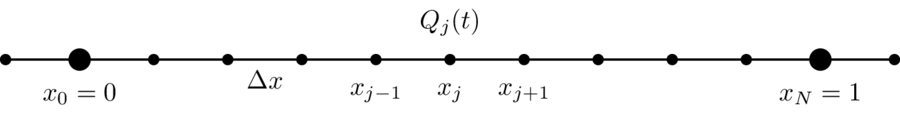

In [7]:
%%tikz -s 900,900
\draw [thick] (-1,0) -- (11,0);
\foreach \x in {-1,...,11}{
    \fill (\x,0) circle(.075);
}
\fill (0,0) circle(.15);
\fill (10,0) circle(.15);

\node[anchor=north] at (0,-0.2) {$x_{0} = 0$};
\node[anchor=north] at (4,-0.2) {$x_{i-1}$};
\node[anchor=north] at (5,-0.2) {$x_{i}$};
\node[anchor=north] at (6,-0.2) {$x_{i+1}$};
\node[anchor=north] at (10,-0.2) {$x_N = 1$};
\node[anchor=south] at (5,0.2) {$Q_i(t)$};
\node[anchor=north] at (2.5,-0.025) {$\Delta x$};

We can approximate the spatial derivative as

\begin{equation*}
q_{xx}(x_i,t) \approx \frac{Q_{i-1}(t) - 2 Q_i(t) + Q_{i+1}(t)}{(\Delta x)^2}
\end{equation*}

In this approach, we convert our diffusion equation to a coupled system of ODEs in the variables $Q_i(t)$, $i = 0, 1, ..., N$ by making the following replacements : 

\begin{equation*}
\begin{aligned}
q_t(x_i,t) & \rightarrow Q_i'(t) \\
q_{xx}(x_i,t) & \rightarrow \frac{Q_{i-1}(t) - 2 Q_i(t) + Q_{i+1}(t)}{(\Delta x)^2}
\end{aligned}
\end{equation*}

Replacing these continuous expression for discrete ones, we get a coupled system of ODEs, given by

\begin{equation}
Q_i'(t) =  \frac{Q_{i-1}(t) - 2 Q_i(t) + Q_{i+1}(t)}{(\Delta x)^2}
\end{equation}

The unknown functions are $Q_0(t), Q_1(t), ..., Q_N(t)$.

<a id="BC"></a>

### Impose no-flux boundary conditions

For values of $i = 0$ and $i=N$, we use our boundary conditions to define values for $Q_{-1}(t)$ and $Q_{N+1}(t)$, needed to define our equations for $Q_0(t)$ and $Q_N(t)$.   We discretize the boundary conditions as 

\begin{equation*}
q_x(0,t) \approx \frac{Q_1(t) - Q_{-1}(t)}{2\Delta x}
\end{equation*}

and 

\begin{equation*}
q_x(1,t) \approx \frac{Q_{N+1}(t) - Q_{N-1}(t)}{2\Delta x}
\end{equation*}

Setting these equal to 0, and then solving for the values $Q_{-1}(t)$ and $Q_{N+1}(t)$, we get

\begin{equation}
Q_{-1}(t)  = Q_{1}(t)
\end{equation}

and

\begin{equation}
Q_{N+1}(t)  = Q_{N-1}(t)
\end{equation}

<a id="FE"></a>

### The Forward Euler Method

Using these values, our system of ODEs is now well-defined for each equation.  For simplicity, we describe the system as 

\begin{equation*}
\mathbf Q'(t) = A \mathbf Q(t)
\end{equation*}

where now $A$ is the tri-diagonal matrix with diagnonal entries $A_{ii} = -2/(\Delta x)^2$ and super- and sub-diagonals equal to $1/(\Delta x)^2$.  The entries in the upper right and lower left corners of $A$ may modified to account for boundary conditions.  In practice, we won't use the matrix to implement the scheme, so for the purposes of this discussion, we will assume that these corner values are not modified.    The vector $\mathbf Q(t)$ contains the unknowns $Q_0(t), Q_1(t), ..., Q_N(t)$.  

We now have a system of coupled ODEs and so we can apply standard numerical methods for solving such systems.  One standard method is the Forward Euler (FE) method.  We discretize our time interval $[0,T]$ into equally spaced time values $t_n = n\Delta t$, for $n = 0,1,2, ..., M$.  We denote the solution $\mathbf Q(t_n) \equiv \mathbf Q^n$.   The FE time stepping scheme then looks like: 

\begin{equation*}
\begin{aligned}
\mathbf Q^{n+1} & = \mathbf Q^n + \Delta t A \mathbf Q^n \\
& = (I + \Delta t A) \mathbf Q^n
\end{aligned}
\end{equation*}

In practice, we do not form the matrix $A$ explicitly, but rather apply the matrix operator in a loop.  

<a id="dt"></a>

### Choosing a stable time step

To choose a time step $\Delta t$, we must ensure that the solution does not grow with time.  That is, we would like to maintain

\begin{equation*}
\parallel \mathbf Q^{n+1}\parallel \; < \; \parallel \! \mathbf Q^{n} \parallel
\end{equation*}

For the Forward Euler method, we can guarantee this by ensuring that

\begin{equation*}
-1 < 1 + \Delta t \lambda^p(A) < 1, \qquad p = 1,2,3,..., N+1
\end{equation*}

where $\lambda^p(A)$ is the $p^{th}$ eigenvalue of  $A$.   From this, we get a constraint on the time step $\Delta t$ given by 

\begin{equation*}
0 < \Delta t < \frac{-2}{\lambda^p(A)}, \qquad p = 1,2,3,...,N+1
\end{equation*}

To ensure that $\Delta t$ satisfies the constraint for all $p$, we have to find the smallest value of $-2/\lambda^p(A)$.   The eigenvalues of $A$  are given by 

\begin{equation*}
\lambda^p(A) = \frac{2}{(\Delta x)^2} \left(\cos(\pi p \Delta x) - 1\right) < 0
\end{equation*}

so that 
\begin{equation*}
\frac{(\Delta x)^2}{4} < \frac{-1}{\lambda^p(A)}
\end{equation*}

From this we get that our time step for the Forward Euler scheme must satisfy

\begin{equation*}
(\Delta t)_{stable} < \frac{(\Delta x)^2}{2}
\end{equation*}

In the code `heat_serial.c`,  we choose a time step that is both stable  and that evenly divides our final time $T$.  

<a id="code"></a>
<hr style="border-width:2px;border-color:black" />

## Pseudo-code for solving the 1d heat equation using Forward Euler 

Below is a pseudo-code for a basic time stepping scheme for the 1d heat equation.  The complete code is in `heat_serial.c`.  

    dx = 1/N;
    dx2 = dx*dx;

    dt_stable = 0.9*dx2/2;
    M = ceil(T/dt_stable) + 1;
    dt = T/M;

    /* Initialize q */
    for(i = -1; i <= N+1; i++)
    {
        x = i*dx;
        qn[i] = init(x);
    }

    /* Time step to get the solution in time */
    for(n = 0; n <= M; n++)
    {
        /* Apply no-flux boundary conditions */
        qn[-1] = qn[1]
        qn[N+1] = qn[N-1]
    
        /* Update each qn[i] */
        for(i = 0; i <= N; i++)
        {
            qnp1[i] = qn[i] + dt*(qn[i-1] - 2*qn[i] + qn[i+1])/dx2;
        }
        
        /* Store time step every M/nout time steps */
        
        qn = qpn1;     
    }

<a id="heat2d"></a>

<hr style="border-width:4px"></hr>

## The 2d heat equation

The non-dimensional heat equation in two dimensions is given by 

\begin{equation*}
q_t = \nabla^2 q
\end{equation*}

where now $q(x,y,t)$ is a function of two spatial variables $\mathbf x = (x,y)$ and $\nabla^2 q$ is the 2d Laplacian given by 

\begin{equation*}
\nabla^2 q \equiv q_{xx} + q_{yy}
\end{equation*}

In analogy with the 1d example shown above, we solve this problem in the domain $[0,1]\times [0,1]$ over a time interval $[0,T]$.  As in the 1d case, we will apply no-flux boundary conditions on each edge of our unit square domain. 

\begin{equation*}
q_x(0,y,t) = q_x(1,y,t) = q_y(x,0,t) = q_y(x,1,t) = 0
\end{equation*}

The Method-of-Lines approach described above extends to 2d in a very natural way.  The discrete mesh is now a two-dimensional mesh in points $\mathbf x_{ij} \equiv (x_i,y_j)$ on the domain $[0,1] \times [0,1]$ using $N_x$ mesh cells in the x-direction and $N_y$ mesh cells in the y direction.  For a square domain, it makes sense to choose $N_x = N_y$, although in what follows we do not make this assumption.

The general mesh consisting of points $(x_i,y_j)$ is given by 

\begin{equation*}
\begin{aligned}
x_i & = i\Delta x, \qquad i = 0,1,2, ..., N_x \\
y_j & = j\Delta y, \qquad j = 0,1,2, ..., N_y
\end{aligned}
\end{equation*}

where $\Delta x = 1/N_x$ and $\Delta y = 1/N_y$. 

Our semi-discrete system in 2d in terms of functions $Q_{ij}(t) \approx q(x_i,y_j,t)$ is given by

\begin{equation}
Q_{ij}'(t) =  \frac{Q_{i-1,j}(t) - 2 Q_{ij}(t) + Q_{i+1,j}(t)}{(\Delta x)^2} + 
\frac{Q_{i,j-1}(t) - 2 Q_{ij}(t) + Q_{i,j+1}(t)}{(\Delta y)^2}
\end{equation}

A critical difference between 1d and 2d is that in 2d, our time step restriction is given by

\begin{equation*}
(\Delta t)_{stable} < \frac{\min[(\Delta x)^2,(\Delta y)^2]}{4}
\end{equation*}

Notice the factor of 4 rather than 2.   

<a id="pseudo2"></a>
<hr style="border-width:2px"></hr>

## Pseudo-code for solving the 2d heat equation using Forward Euler 

Below is a pseudo-code for a basic time stepping scheme for the 2d heat equation on the domain $[0,1] \times [0,1]$ over the time span $t \in [0,T]$.  

    dx = 1/Nx;
    dy = 1/Ny;
    dx2 = dx*dx;
    dy2 = dy*dy;

    dsmin = (dx < dy) ? dx : dy;
    dt_stable = 0.9*dsmin^2/4;
    M = ceil(T/dt_stable) + 1;
    dt = T/M;

    /* Initialize q */
    for(i = -1; i <= Nx+1; i++)
    {
        for(j = -1; j <= Ny+1; j++)
        {
            x = i*dx;
            y = j*dy;
            qn[i][j] = init(x,y);
        }
    }

    /* Time step to get the solution in time */
    for(n = 0; n <= M; n++)
    {
        /* Apply no-flux boundary conditions */
        for(j = 0; j <= Ny; j++)
        {        
            qn[-1][j] = qn[1][j]
            qn[Nx+1][j] = qn[Nx-1][j]
        }
        for(i = 0; i <= Nx; i++)
        {        
            qn[i][-1] = qn[i][1]
            qn[i][Ny+1] = qn[i][Ny-1]
        }

        /* Update each qn[i][j] */
        for(i = 0; i <= Nx; i++)
        {
            for(j = 0; j <= Ny; j++)
            {
                qxx = (qn[i-1][j] - 2*qn[i][j] + qn[i+1][j])/dx2;
                qyy = (qn[i][j-1] - 2*qn[i][j] + qn[i][j+1])/dy2;
                qnp1[i][j] = qn[i][j] + dt*(qxx + qyy);
            }
        }
        
        /* Store time step every M/nout time steps .... */
        
        qn = qpn1;     
    }

<hr style="border-width:2px, border-style:solid">

If you would like more details on the above, see 

[Finite Difference Methods for Ordinary and Partial Differential Equations: Steady-State and Time-Dependent Problems](https://epubs.siam.org/doi/book/10.1137/1.9780898717839).  

Using this link,  you will be able to download the book for free through the BSU libraries.   

<a id="plotting"></a>
<hr style="border-width:4px;border-color:coral" />

## Running and plotting the solutions to the  heat equation

<hr style="border-width:4px;border-color:coral" />

The serial code for the 1d heat equation provided with this homework can be run and plotted  using the code below. 

Modify this code to plot the 2d results.   

In [2]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [6]:
%%bash

# Usage :  
#    $ heat <N> <nout>
# where <nout> is the number of output files to create including first and last 
# time steps

rm -rf heat

gcc -o heat heat_serial.c -lm

time heat 64 21

mpicc -o heat  heat_serial.c -lm



real	0m0.031s
user	0m0.003s
sys	0m0.016s


In [7]:
# Open file for reading; use binary mode
fout = open("heat.out","rb")

# Read meta data
dt_meta = dtype([('N','int32'),('a','d'),('b','d'),('M','int32')])
d = fromfile(fout,dtype=dt_meta, count=1)[0]

# create dictionary containing meta data
parms = dict(zip(dt_meta.fields,d))

# Print meta data from dictionary
print("N = {N:d}\nM = {M:d}\na = {a:g}\nb = {b:g}".format(**parms))

# Assign values in tuple directly (for use below)
N,a,b,M = d

# Read solution data
dt_heat = dtype([('t','d'),('q','d',N+1)])  
data = fromfile(fout,dtype=dt_heat)
Mout = len(data) # Number of time steps output.
print("M (out) = {:d}".format(Mout))

# Close file
fout.close()

N = 64
M = 1079
a = -1
b = 1
M (out) = 21


<IPython.core.display.Javascript object>


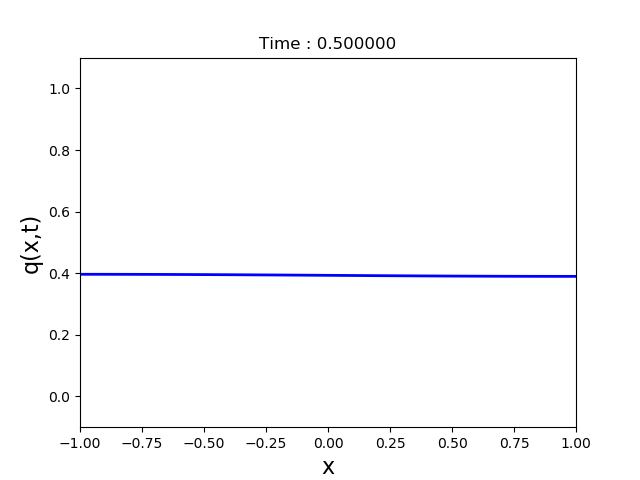

In [8]:
fig = figure(1)
clf()

# Plot the initial conditions
q = data[0][1]
x = linspace(a,b,N+1)

hdl, = plot(x,q,linewidth=2,color='b',label='Computed solution')
tstr = 'Time : {:.6f}'.format
htitle = title(tstr(0))

xlabel('x',fontsize=16)
ylabel('q(x,t)',fontsize=16)
xlim([a,b])
ylim([-0.1,1.1])
fig.canvas.draw()  
pause(0.5)

# Plot solution at Mout time steps.
for n in range(1,Mout):
    t = data[n][0];
    q = data[n][1];

    hdl.set_ydata(q)
    htitle.set_text(tstr(t))
    
    # Refresh plot; update title
    fig.canvas.draw()      

    pause(0.2)    